In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings("ignore")

C:\Users\ulasz\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\ulasz\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
# wczytanie danych
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [5]:
#pipeline do obróbki danych
cols_numerical = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi']

transformer_numerical = Pipeline(steps = [
    ('num_trans', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers = [
    ('numerical', transformer_numerical, cols_numerical)
])

pipe = Pipeline(steps = [
                ('preprocessor', preprocessor)
            ])


In [6]:
scaled_train_data = pipe.fit_transform(train_data)
X_train = pd.DataFrame(scaled_train_data, columns=cols_numerical)
y_train = train_data['price_range'].values.ravel()
scaled_test_data = pipe.fit_transform(test_data)
X_test = pd.DataFrame(scaled_test_data, columns=cols_numerical)
y_test = test_data['price_range'].values.ravel()

SelectKBest z modelem KNN

In [7]:
# zakres wartości k (liczba kolumn w orginalnej ramce danych)
k_values = range(1, 21)


results = {}


for k in k_values:

    pipeline = Pipeline([
        ('select_k_best', SelectKBest(score_func=chi2, k=k)),
        ('knn', KNeighborsClassifier())
    ])

    # siatka parametrów
    param_grid = {
        'knn__n_neighbors': [3, 5, 7],
        'knn__weights': ['uniform', 'distance']
    }


    grid_search = GridSearchCV(pipeline, param_grid, cv=5)
    grid_search.fit(X_train, y_train)


    best_model = grid_search.best_estimator_


    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    results[k] = {
        'accuracy': accuracy,
        'selected_features': X_train.columns[best_model.named_steps['select_k_best'].get_support()]
    }

# Wydrukuj wyniki
for k, result in results.items():
    print(f"k={k}, Accuracy={result['accuracy']}")
    print("Selected Features:")
    print(result['selected_features'])
    print()

k=1, Accuracy=0.78
Selected Features:
Index(['ram'], dtype='object')

k=2, Accuracy=0.79
Selected Features:
Index(['battery_power', 'ram'], dtype='object')

k=3, Accuracy=0.9525
Selected Features:
Index(['battery_power', 'px_width', 'ram'], dtype='object')

k=4, Accuracy=0.925
Selected Features:
Index(['battery_power', 'px_height', 'px_width', 'ram'], dtype='object')

k=5, Accuracy=0.925
Selected Features:
Index(['battery_power', 'int_memory', 'px_height', 'px_width', 'ram'], dtype='object')

k=6, Accuracy=0.91
Selected Features:
Index(['battery_power', 'int_memory', 'px_height', 'px_width', 'ram',
       'touch_screen'],
      dtype='object')

k=7, Accuracy=0.8925
Selected Features:
Index(['battery_power', 'int_memory', 'mobile_wt', 'px_height', 'px_width',
       'ram', 'touch_screen'],
      dtype='object')

k=8, Accuracy=0.885
Selected Features:
Index(['battery_power', 'blue', 'int_memory', 'mobile_wt', 'px_height',
       'px_width', 'ram', 'touch_screen'],
      dtype='object')



Najlepsze accuracy wyszło dla k = 3 i k = 4, a dodatkowo zmienne px_width i px_height są mocno skorelowane więc stworzymy nową kolumnę która jest iloczynem tych dwóch, czyli polem powierzchni wyświetlacza

In [9]:
#łączymy px height i width
X_train['px_area'] = X_train['px_height'] * X_train['px_width']
X_test['px_area'] = X_test['px_height'] * X_test['px_width']
X_train = X_train[['battery_power', 'px_area', 'ram']]
X_test = X_test[['battery_power', 'px_area', 'ram']]



Crossvalidation na całym zbiorze

In [10]:
# łączymy ze sobą dane treningowe i testowe do crossvalidation
X = pd.concat([X_test, X_train], axis=0)
y = np.concatenate([y_test, y_train])


Za pomocą crossvalidation wybieramy najlepsze hiperparmetry dla KNN, SVM i DecisionTree a potem na nich robimy stacking

In [17]:
knn = KNeighborsClassifier()
svm = SVC()
decision_tree = DecisionTreeClassifier()
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}


param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}


param_grid_decision_tree = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}


grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5)
grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_


grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_


grid_search_decision_tree = GridSearchCV(decision_tree, param_grid_decision_tree, cv=5)
grid_search_decision_tree.fit(X_train, y_train)
best_decision_tree = grid_search_decision_tree.best_estimator_


stacked_model = StackingClassifier(
    estimators=[('knn', best_knn), ('svm', best_svm), ('decision_tree', best_decision_tree)],
    final_estimator=LogisticRegression()
)


stacked_model.fit(X_train, y_train)

y_pred = stacked_model.predict(X_test)


print("Classification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        94
           1       0.95      1.00      0.98        98
           2       0.98      0.94      0.96        99
           3       0.98      0.98      0.98       109

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



In [12]:
cm = confusion_matrix(y_test, y_pred)

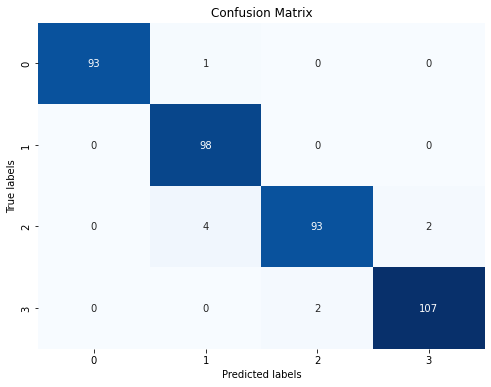

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Za pomocą crossvalidation określamy średni wynik naszego finalnego modelu

In [14]:
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']


results = {}


kfold = KFold(n_splits=6, shuffle=True, random_state=1)


pipeline = Pipeline([('classifier', stacked_model)])
cv_results = cross_validate(pipeline, X, y, cv=kfold, scoring=scoring)


results['Stacked Model'] = cv_results


for name, result in results.items():
    print(f'{name}:')
    for metric, scores in result.items():
        print(f'{metric}')
        print(f'Średnia: {scores.mean()}, Odchylenie standardowe: {scores.std()}')
    print()

Stacked Model:
fit_time
Średnia: 0.29168736934661865, Odchylenie standardowe: 0.022213394787708233
score_time
Średnia: 0.022921323776245117, Odchylenie standardowe: 0.001986152900416372
test_accuracy
Średnia: 0.9414804025582469, Odchylenie standardowe: 0.016377895099262532
test_precision_macro
Średnia: 0.9410845557131386, Odchylenie standardowe: 0.01617204102802497
test_recall_macro
Średnia: 0.9418730346357229, Odchylenie standardowe: 0.01519052908542549
test_f1_macro
Średnia: 0.941286440611316, Odchylenie standardowe: 0.01580293240275708



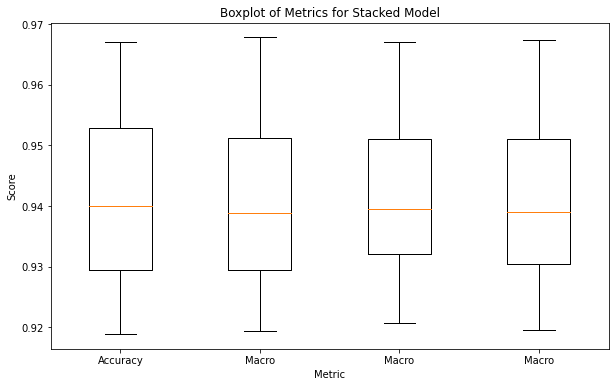

In [15]:
import matplotlib.pyplot as plt


metrics = ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']


fig, ax = plt.subplots(figsize=(10, 6))


metric_scores = [results['Stacked Model'][metric] for metric in metrics]


ax.boxplot(metric_scores, labels=[metric.split('_')[-1].capitalize() for metric in metrics])
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Boxplot of Metrics for Stacked Model')

plt.show()
